In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

!pip install coinmetrics-api-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 2.0 MB/s eta 0:00:00


In [39]:
from coinmetrics.api_client import CoinMetricsClient

client = CoinMetricsClient()

print(client)

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# 'SplyCntCur' - this is for the supply count of the current coin
# 'CapMrktCurUSD' - this is for the market capitalization of the current coin
# 'PriceUSD' - this is for the price of the current coin
# 'TxTfrValAdjUSD' - this is for the adjusted transaction value in USD
# 'TxTfrValUSD' - this is for the transaction value in USD
# 'TxTfrCnt' - this is for the transaction count
# 'IssContNtv' - this is for the native issuance count
# 'IssContPctAnn' - this is for the annual percentage of the issuance count
#
# metrics = client.get_asset_metrics(assets='btc', metrics=['PriceUSD','HashRate','TxTfrCnt','AdrActCnt', 'SplyCur'], start_time="2013-01-01", end_time="2023-01-02", frequency='1d')
# metrics = client.get_asset_metrics(assets='btc', metrics=['PriceUSD','HashRate','TxTfrCnt','AdrActCnt', 'SplyCur'], start_time="2023-01-01", end_time="2024-01-02", frequency='1d')
metrics = client.get_asset_metrics(assets='btc', metrics=['PriceUSD','HashRate','TxTfrCnt','AdrActCnt', 'SplyCur'], start_time="2015-01-01", end_time="2024-01-02", frequency='1d')

# PriceUSD	Bitcoin market price in USD
# SplyCur	Current circulating supply (BTC in existence)
# HashRate	Network hash rate (security strength)
# Difficulty	Mining difficulty (how hard it is to mine a block)
# TxTfrCnt	Number of transactions per day
# TxTfrValUSD	Total daily value transferred (in USD)
# AdrActCnt	Number of active addresses (daily)
# AdrNewCnt	Number of new addresses created
# BlkCnt	Number of blocks mined per day
# BlkSizeMean	Average block size (in bytes)
# FeeMeanUSD	Average transaction fee (in USD)
# FeeTotUSD	Total transaction fees paid that day (USD)
# IssTotNtv	Total issuance (BTC minted per day)
# RevNtv	Miner revenue (BTC)
# RevUSD	Miner revenue (USD)
# SplyFuture	Amount of BTC not yet mined (future supply)
# TxCnt	Total number of transactions
# TxTfrCnt	Total number of value transfers (non-zero transactions)
# PriceBTC	Price in BTC (used for altcoins mostly)
# TxTfrValAdjNtv	Adjusted transaction volume (removes self-sends, spam)



In [41]:
metrics = pd.DataFrame(metrics)

metrics.head()

metrics.to_csv("LSTM_File_.csv", index=False)

df = metrics.copy()


In [42]:
df['time'] = pd.to_datetime(df['time'])
df.sort_values('time', inplace=True)

df['TxTfrCnt'] = pd.to_numeric(df['TxTfrCnt'], errors='coerce')
df['AdrActCnt'] = pd.to_numeric(df['AdrActCnt'], errors='coerce')
df['SplyCur'] = pd.to_numeric(df['SplyCur'], errors='coerce')
df['PriceUSD'] = pd.to_numeric(df['PriceUSD'], errors='coerce')

df['TxTfrCnt_per_address'] = df['TxTfrCnt'] / df['AdrActCnt']
df['SplyCur_per_address'] = df['SplyCur'] / df['AdrActCnt']

# Target: future price (e.g., 1-day ahead)
df['PriceUSD_target'] = df['PriceUSD'].shift(-1)
df['TxTfrCnt_per_address'] = df['TxTfrCnt'] / df['AdrActCnt']
df['SplyCur_per_address'] = df['SplyCur'] / df['AdrActCnt']


# Add technical indicators
# Moving averages
df['MA_7'] = df['PriceUSD_target'].rolling(window=7).mean()
df['MA_30'] = df['PriceUSD_target'].rolling(window=30).mean()
# Trend_Strength
df['MA_7_30_ratio'] = df['MA_7'] / df['MA_30']

# Volatility
# Added volatility in the last 30 days
df['Volatility_30'] = df['PriceUSD_target'].rolling(window=30).std()

 # Drop rows with NaNs from shifting
df.dropna(inplace=True)


In [43]:
# Base features
# X = df[['HashRate', 'TxTfrCnt', 'AdrActCnt', 'SplyCur', 'PriceUSD_target', 'MA_7', 'MA_30', 'MA_7_30_ratio', 'Volatility_30']].values

# Just onchain values finalized with all the onchain metrics
X = df[['HashRate', 'TxTfrCnt', 'AdrActCnt', 'SplyCur', 'PriceUSD']].values

# All the onchain metrics
# X = df[['PriceUSD', 'HashRate', 'TxTfrCnt',
#         'AdrActCnt', 'BlkCnt',
#         'FeeMeanUSD', 'FeeTotUSD', 'IssTotNtv', 'RevNtv', 'RevUSD',
#         'SplyCur','TxCnt', 'TxTfrValAdjNtv']]

# Just the price usd
# X = df[['PriceUSD']]
# Base onchain metrics usage
# X = df[['PriceUSD','HashRate','TxTfrCnt','AdrActCnt', 'SplyCur']].values

y = df['PriceUSD_target'].values


In [44]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

import joblib

joblib.dump(scaler_X, "btc_scaler_X_PriceUSD_v2.pkl")
joblib.dump(scaler_y, "btc_scaler_y_PriceUSD_v2.pkl")


def create_sequences(X, y, time_steps=60):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

# Choose an appropriate sequence length (e.g., 60 days)
time_steps = 60
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

In [46]:
# Reshape the input to be 3D [samples, time steps, features]
from sklearn.model_selection import train_test_split

# Split into train (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
n_features = X_train.shape[2]

In [ ]:
# Building the LSTM model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
import tensorflow as tf

from tensorflow.keras.optimizers import Adam


# BIDIRECTIONAL LSTM Model Base Modifications

model = Sequential()
# Change the number of neurosn from 100 to 356
model.add(Bidirectional(LSTM(units=356, return_sequences=True, activation = tf.tanh),
                        input_shape=(time_steps, n_features)))

# changed dropout from 0.4 to 0.3
model.add(Dropout(0.1))
# changing to 100 units of neurons
model.add(Bidirectional(LSTM(units=356,return_sequences=True, activation=tf.tanh)))
# changed dropout from 0.2 to 0.3
# changed dropout from 0.3 to 0.4
model.add(Dropout(0.1))
# 3rd (and final) Bi‑LSTM: returns only the last output vector
model.add(Bidirectional(
    LSTM(units=356, return_sequences=False)
))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
# Train the model with a validation split
from tensorflow.keras.callbacks import EarlyStopping

# Add early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=600,
    # Epoch increased from 200 to 600
    # Increased Batch_size from 32 to 64
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/600
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - loss: 0.1079 - val_loss: 0.0169
Epoch 2/600
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0012 - val_loss: 0.0084
Epoch 3/600
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 8.9464e-04 - val_loss: 0.0046
Epoch 4/600
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 7.4582e-04 - val_loss: 0.0034
Epoch 5/600
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 6.8298e-04 - val_loss: 0.0049
Epoch 6/600
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 7.1883e-04 - val_loss: 0.0049
Epoch 7/600
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 7.3312e-04 - val_loss: 0.0067
Epoch 8/600
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 5.4706e-04 - val_loss: 0.0025
Epoch 9/600
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 3.9555e-04 - val_loss: 0.0023
Epoch 10/600
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 7.5800e-04 - val_loss: 0.0024
Epoch 11/600
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 4.9970e-04 - val_loss: 0.0044
Epoch 12/600

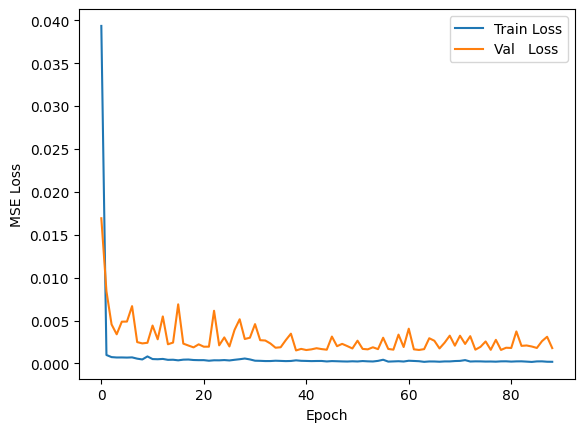

In [49]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
model.save('Bit_Coin_Price_Prediction_LSTM_Model_4chain.keras')

plt.plot(history.history['loss'],   label='Train Loss')
plt.plot(history.history['val_loss'], label='Val   Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [50]:
# Evaluation and make predictions
# Predict on test data
y_pred_scaled = model.predict(X_test)

# Inverse transform to get actual price values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
print(f"RMSE for testing: {rmse}")
print(f"MAE for testing: {mae}")

def directional_accuracy(y_true, y_pred):
    y_true_direction = np.sign(np.diff(y_true.flatten()))
    y_pred_direction = np.sign(np.diff(y_pred.flatten()))
    return np.mean(y_true_direction == y_pred_direction)

dir_acc = directional_accuracy(y_test_actual, y_pred)

print(f"RMSE for testing: {rmse}")
print(f"MAE for testing: {mae}")
print(f"Directional Accuracy: {dir_acc:.4f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
RMSE for testing: 1320.5965140554492
MAE for testing: 1026.401086837907
RMSE for testing: 1320.5965140554492
MAE for testing: 1026.401086837907
Directional Accuracy: 0.4718


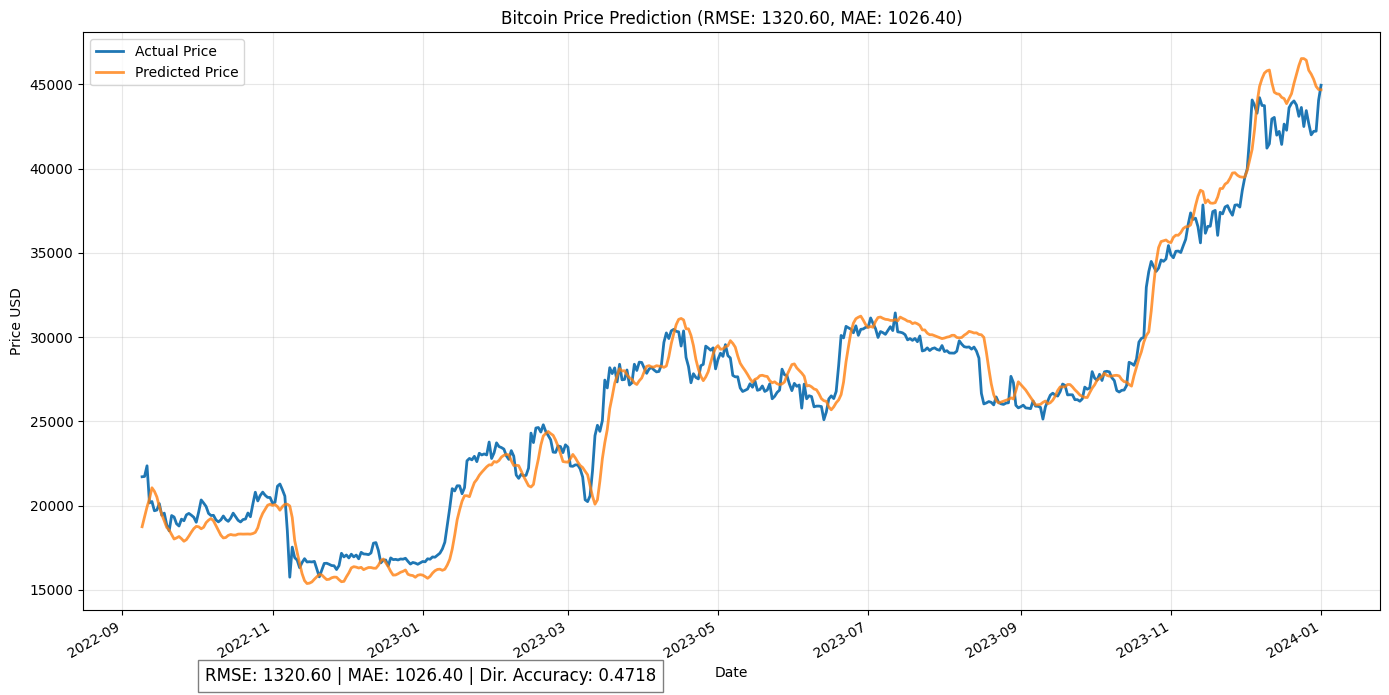

In [ ]:
# # Visualizing the result


# Get the dates for the test set
# We need to find the dates that correspond to our test set
test_dates = df['time'].iloc[-(len(y_test_actual)):]

# Visualizing the result with dates
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_actual, label='Actual Price', linewidth=2)
plt.plot(test_dates, y_pred, label='Predicted Price', linewidth=2, alpha=0.8)
plt.title(f'Bitcoin Price Prediction (RMSE: {rmse:.2f}, MAE: {mae:.2f})')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.legend()
plt.grid(alpha=0.3)

# Format x-axis to show dates properly
plt.gcf().autofmt_xdate()
plt.tight_layout()

# Add text annotation for metrics
plt.figtext(0.15, 0.02, f"RMSE: {rmse:.2f} | MAE: {mae:.2f} | Dir. Accuracy: {dir_acc:.4f}",
            ha="left", fontsize=12, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

plt.show()

The code below is for the multi-agent part of the system

Starting tournament simulation...
Day 100: BTC Price = 59932.93
Day 100: BTC Price = 59932.93
Day 100: BTC Price = 59932.93
Day 100: BTC Price = 59932.93
Day 100: BTC Price = 59932.93
Day 200: BTC Price = 29766.66
Day 200: BTC Price = 29766.66
Day 200: BTC Price = 29766.66
Day 200: BTC Price = 29766.66
Day 200: BTC Price = 29766.66
Day 300: BTC Price = 60564.57
Day 300: BTC Price = 60564.57
Day 300: BTC Price = 60564.57
Day 300: BTC Price = 60564.57
Day 300: BTC Price = 60564.57

Final Tournament Results:
GreedyBuyer Final Balance: $95.96 (-4.04% growth)
CautiousHolder Final Balance: $92.32 (-7.68% growth)
PartialTrader Final Balance: $87.67 (-12.33% growth)
RandomTrader Final Balance: $71.09 (-28.91% growth)
MovingAverageTrader Final Balance: $81.02 (-18.98% growth)


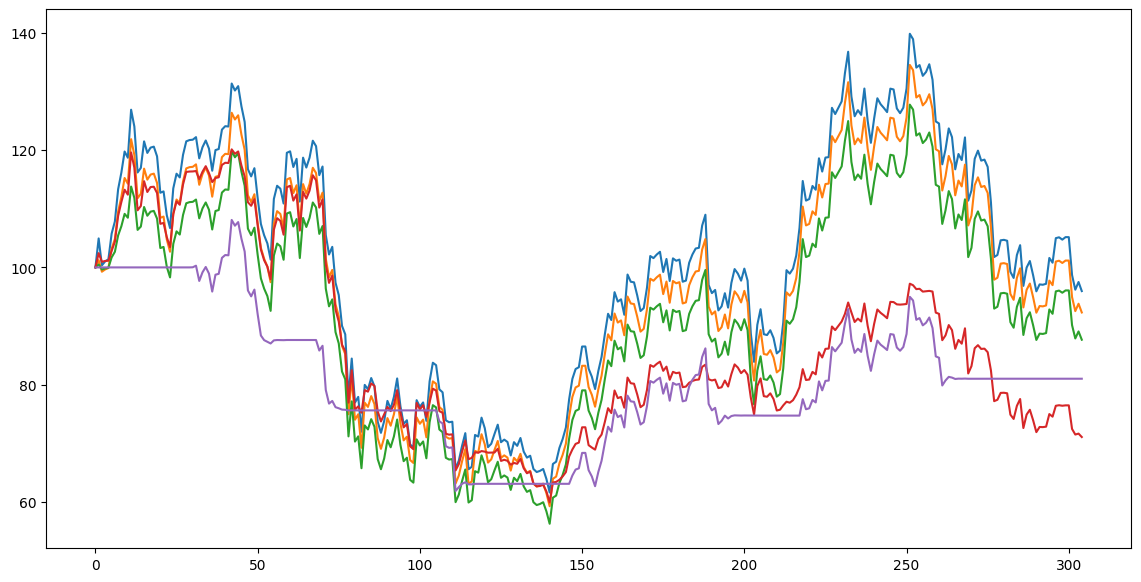

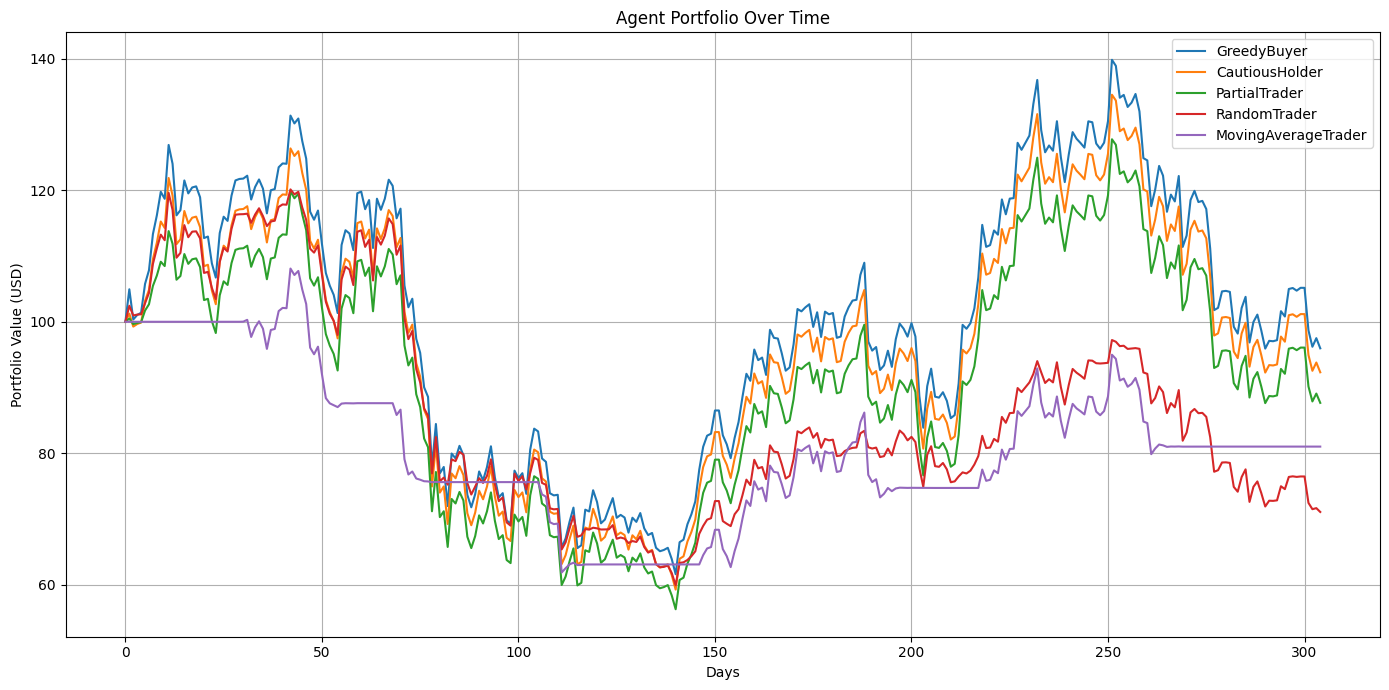

In [52]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib

# --- Load real feature data ---
df = pd.read_csv("/content/LSTM_File_.csv")
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')

# Filter the data
start_date = '2021-01-01'
end_date = '2021-12-31'
df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

features = df[['PriceUSD', 'HashRate', 'TxTfrCnt', 'AdrActCnt', 'SplyCur']].values
prices = df['PriceUSD'].values

# --- Define the Agent class ---
class LSTMTradingAgent:
    def __init__(self, name, model, scaler_X, scaler_y, initial_cash=100):
        self.name = name
        self.model = model
        self.scaler_X = scaler_X
        self.scaler_y = scaler_y
        self.initial_cash = initial_cash
        self.cash = initial_cash
        self.crypto = 0
        self.history = []

    def predict_price(self, X_window):
        X_scaled = self.scaler_X.transform(X_window)
        X_scaled = X_scaled.reshape(1, *X_scaled.shape)
        y_pred_scaled = self.model.predict(X_scaled, verbose=0)
        predicted_price = self.scaler_y.inverse_transform(y_pred_scaled)[0, 0]

        # 🎯 Add small noise (simulate uncertainty)
        noise = np.random.normal(0, 0.01)  # ~1% noise
        predicted_price = predicted_price * (1 + noise)
        return predicted_price

    def act(self, X_window, price_now):
        raise NotImplementedError("Subclasses should implement this!")

    def get_final_balance(self, price_now):
        return self.cash + self.crypto * price_now


class GreedyBuyer(LSTMTradingAgent):
    def act(self, X_window, price_now):
        predicted_price = self.predict_price(X_window)

        if predicted_price > price_now * 1.001 and self.cash > 0:
            self.crypto += self.cash / price_now
            self.cash = 0
        elif predicted_price < price_now * 0.999 and self.crypto > 0:
            self.cash += self.crypto * price_now
            self.crypto = 0

        self.history.append(self.get_final_balance(price_now))

class CautiousHolder(LSTMTradingAgent):
    def act(self, X_window, price_now):
        predicted_price = self.predict_price(X_window)

        if predicted_price > price_now * 1.05 and self.cash > 0:
            # Only use 25% of cash
            amount = 0.25 * self.cash
            self.crypto += amount / price_now
            self.cash -= amount
        elif predicted_price < price_now * 0.98 and self.crypto > 0:
            # Only sell 50% of crypto
            amount = 0.5 * self.crypto
            self.cash += amount * price_now
            self.crypto -= amount

        self.history.append(self.get_final_balance(price_now))

class PartialTrader(LSTMTradingAgent):
    def act(self, X_window, price_now):
        predicted_price = self.predict_price(X_window)

        if predicted_price > price_now * 1.01 and self.cash > 0:
            amount = 0.10 * self.cash
            self.crypto += amount / price_now
            self.cash -= amount
        elif predicted_price < price_now * 0.99 and self.crypto > 0:
            amount = 0.10 * self.crypto
            self.cash += amount * price_now
            self.crypto -= amount

        self.history.append(self.get_final_balance(price_now))

class RandomTrader(LSTMTradingAgent):
    """Agent that makes random trading decisions"""

    def __init__(self, name, model, scaler_X, scaler_y, initial_cash=100,
                 buy_prob=0.6, sell_prob=0.3, hold_prob=0.1):
        super().__init__(name, model, scaler_X, scaler_y, initial_cash)
        self.buy_prob = buy_prob
        self.sell_prob = sell_prob
        self.hold_prob = hold_prob

    def act(self, X_window, price_now):
        # Generate random decision
        decision = np.random.choice(
            ['BUY', 'SELL', 'HOLD'],
            p=[self.buy_prob, self.sell_prob, self.hold_prob]
        )

        # Execute decision
        if decision == 'BUY' and self.cash > 0:
            # Buy random amount between 10-70% of cash
            buy_pct = np.random.uniform(0.1, 0.7)
            amount = self.cash * buy_pct
            self.crypto += amount / price_now
            self.cash -= amount
        elif decision == 'SELL' and self.crypto > 0:
            # Sell random amount between 10-70% of crypto
            sell_pct = np.random.uniform(0.1, 0.7)
            amount = self.crypto * sell_pct
            self.cash += amount * price_now
            self.crypto -= amount

        self.history.append(self.get_final_balance(price_now))

class MovingAverageTrader(LSTMTradingAgent):
    def __init__(self, name, model, scaler_X, scaler_y, initial_cash=100,
                 short_window=7, long_window=30):
        super().__init__(name, model, scaler_X, scaler_y, initial_cash)
        self.short_window = short_window
        self.long_window = long_window
        self.prices_seen = []

    def act(self, X_window, price_now):
        self.prices_seen.append(price_now)

        # Only act if we have enough price history
        if len(self.prices_seen) >= self.long_window:
            short_ma = np.mean(self.prices_seen[-self.short_window:])
            long_ma = np.mean(self.prices_seen[-self.long_window:])

            if short_ma > long_ma and self.cash > 0:
                # Buy using 50% of cash
                amount = 0.5 * self.cash
                self.crypto += amount / price_now
                self.cash -= amount
            elif short_ma < long_ma and self.crypto > 0:
                # Sell 50% of crypto
                amount = 0.5 * self.crypto
                self.cash += amount * price_now
                self.crypto -= amount

        self.history.append(self.get_final_balance(price_now))





# --- Load trained LSTM model and scalers ---
# model = load_model('/content/Bit_Coin_Price_Prediction_LSTM_Model_4ChainMetrics_Ver2.h5')
model = load_model('/content/Bit_Coin_Price_Prediction_LSTM_Model_4chain.keras')
scaler_X = joblib.load('/content/btc_scaler_X_4ChainMetrics.pkl')
scaler_y = joblib.load('/content/btc_scaler_y_4ChainMetrics.pkl')

# --- Initialize agents ---
# agents = [
#     LSTMTradingAgent(name="BTC_LSTM_Agent", model=model, scaler_X=scaler_X, scaler_y=scaler_y)
# ]

agents = [
    GreedyBuyer(name="GreedyBuyer", model=model, scaler_X=scaler_X, scaler_y=scaler_y),
    CautiousHolder(name="CautiousHolder", model=model, scaler_X=scaler_X, scaler_y=scaler_y),
    PartialTrader(name="PartialTrader", model=model, scaler_X=scaler_X, scaler_y=scaler_y),
    RandomTrader(name="RandomTrader", model=model, scaler_X=scaler_X, scaler_y=scaler_y),
    MovingAverageTrader(name="MovingAverageTrader", model=model, scaler_X=scaler_X, scaler_y=scaler_y)
]


# --- Simulation Loop ---
time_steps = 60
print("Starting tournament simulation...")
for t in range(time_steps, len(prices)):
    X_window = features[t - time_steps:t]
    price_now = prices[t]

    for agent in agents:
        agent.act(X_window, price_now)
        # Optional: print only every 100 steps
        if t % 100 == 0:
          print(f"Day {t}: BTC Price = {price_now:.2f}")

# --- Results ---
print("\nFinal Tournament Results:")
for agent in agents:
    final_balance = agent.get_final_balance(prices[-1])
    growth = (final_balance - agent.initial_cash) / agent.initial_cash * 100
    print(f"{agent.name} Final Balance: ${final_balance:.2f} ({growth:.2f}% growth)")


# --- Plotting ---
plt.figure(figsize=(14, 7))
for agent in agents:
    plt.plot(agent.history, label=agent.name)


plt.figure(figsize=(14, 7))
for agent in agents:
    plt.plot(agent.history, label=agent.name)

plt.title('Agent Portfolio Over Time')
plt.xlabel('Days')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



<ipython-input-59-5d7a620a3877>:292: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


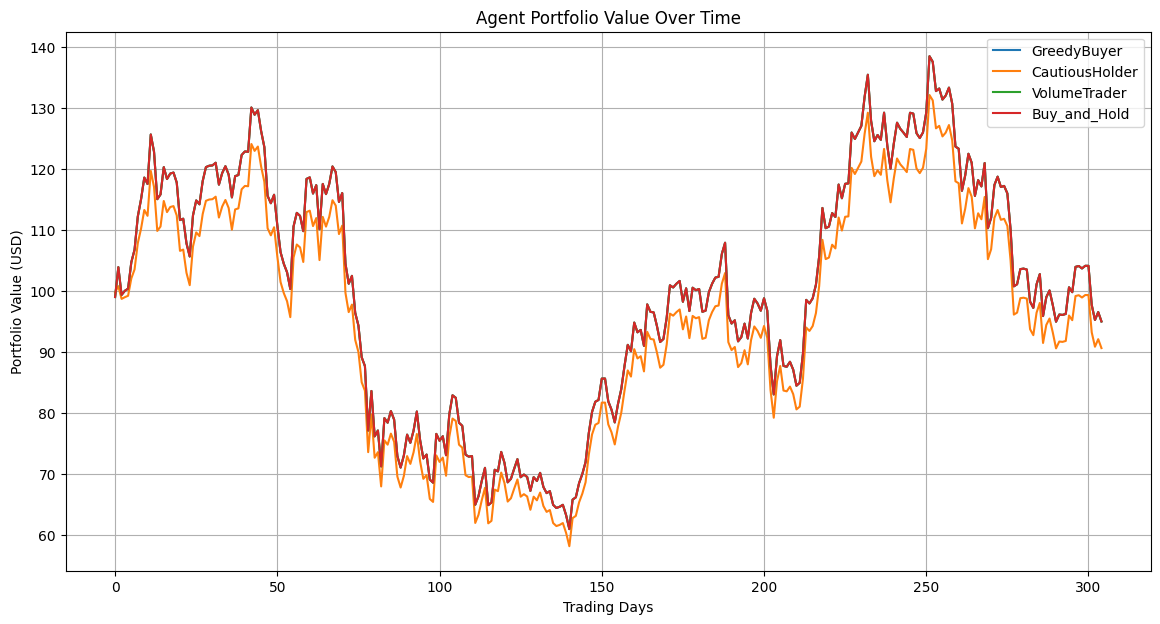

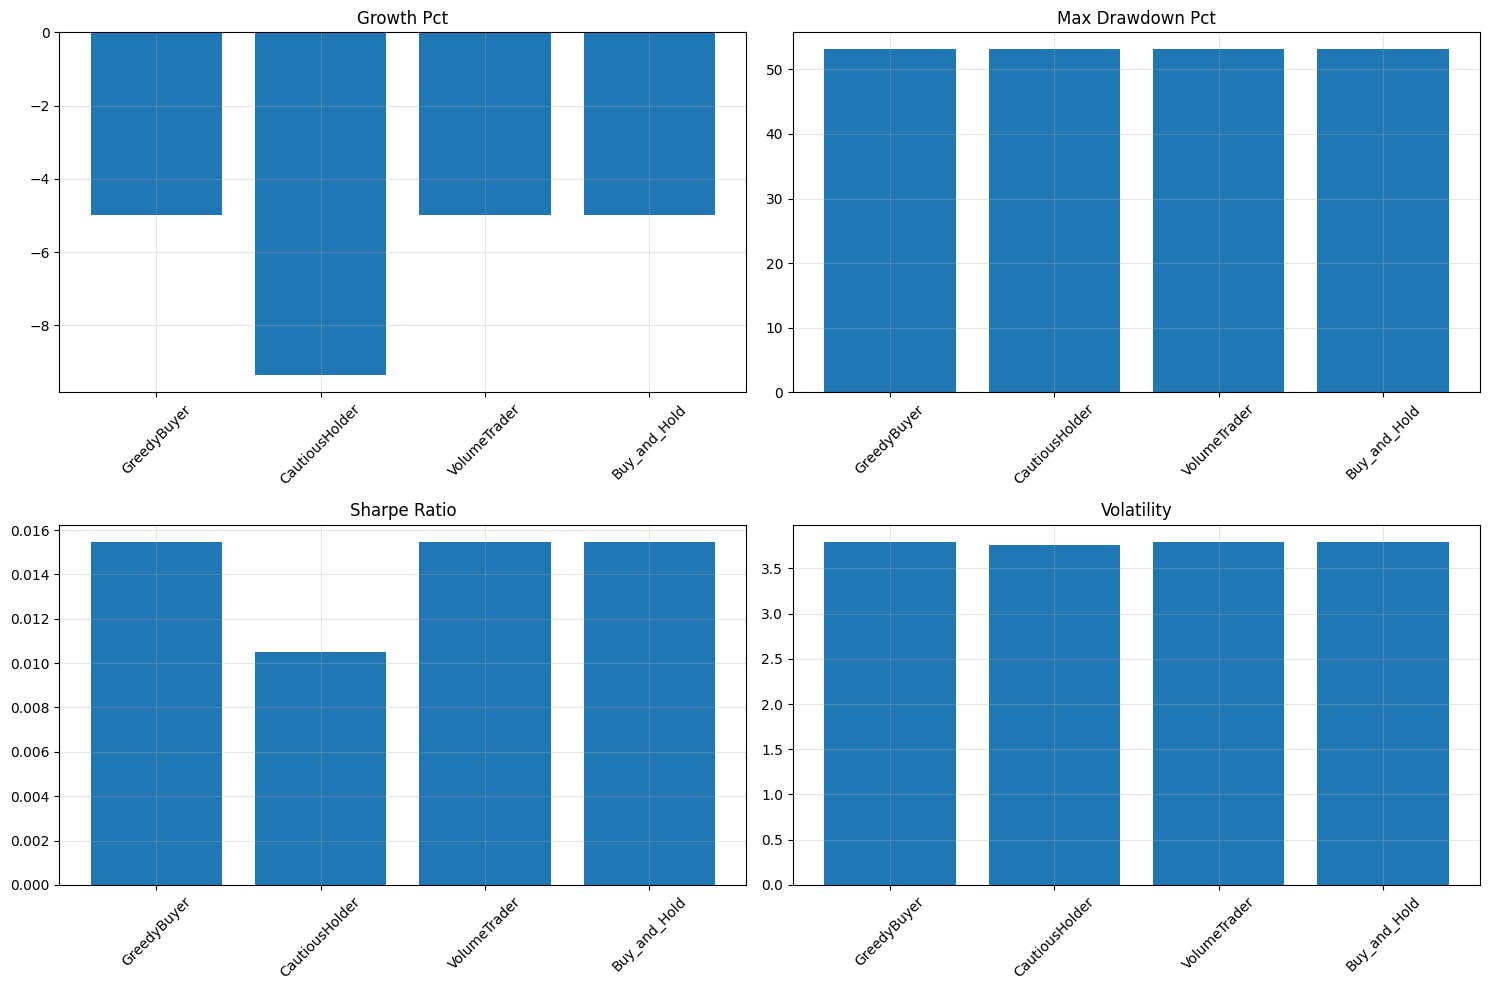

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib
import os
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import logging

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler("trading_sim.log"), logging.StreamHandler()]
)
logger = logging.getLogger("trading_simulation")

class BaseTradingAgent:
    """Base class for all trading agents with common functionality"""

    def __init__(self, name, initial_cash=100):
        self.name = name
        self.initial_cash = initial_cash
        self.cash = initial_cash
        self.crypto = 0
        self.history = []
        self.actions = []  # Track buy/sell/hold actions
        self.transaction_prices = []  # Track prices at transaction times

    def get_final_balance(self, price_now):
        """Calculate final portfolio value"""
        return self.cash + self.crypto * price_now

    def get_performance_metrics(self, prices):
        """Calculate various performance metrics"""
        returns = np.diff(self.history) / self.history[:-1]

        metrics = {
            'final_balance': self.history[-1],
            'growth_pct': (self.history[-1] - self.initial_cash) / self.initial_cash * 100,
            'max_drawdown_pct': self._calculate_max_drawdown(self.history) * 100,
            'sharpe_ratio': np.mean(returns) / np.std(returns) if len(returns) > 0 and np.std(returns) > 0 else 0,
            'volatility': np.std(returns) * 100 if len(returns) > 0 else 0,
            'buy_and_hold_return': (prices[-1] - prices[0]) / prices[0] * 100,
            'num_trades': len([a for a in self.actions if a != 'HOLD'])
        }

        return metrics

    def _calculate_max_drawdown(self, portfolio_values):
        """Calculate maximum drawdown from peak to trough"""
        max_so_far = portfolio_values[0]
        max_drawdown = 0

        for value in portfolio_values:
            if value > max_so_far:
                max_so_far = value
            drawdown = (max_so_far - value) / max_so_far
            max_drawdown = max(max_drawdown, drawdown)

        return max_drawdown

class MomentumTrader(LSTMTradingAgent):
    """Agent that trades based on price momentum and volume trends"""

    def act(self, X_window, price_now):
        # Calculate short and long moving averages (5-day and 20-day)
        short_ma = np.mean(X_window[-5:, 0])  # 5-day price MA
        long_ma = np.mean(X_window[-20:, 0])  # 20-day price MA

        # Calculate momentum and volume trend
        momentum = short_ma / long_ma - 1

        # Volume index (assuming it's in the data - adjust column index as needed)
        volume_trend = np.mean(X_window[-5:, 2]) / np.mean(X_window[-20:, 2]) - 1

        action = "HOLD"

        # Strong buy signal: positive momentum, increasing volume, model agrees
        if momentum > 0.02 and volume_trend > 0 and self.cash > 0:
            amount = min(self.cash, self.cash * (momentum * 10))  # Size based on momentum
            self.crypto += amount / price_now * 0.99  # Account for 1% fee
            self.cash -= amount
            action = "BUY"

        # Strong sell signal: negative momentum, increasing volume
        elif momentum < -0.02 and volume_trend > 0 and self.crypto > 0:
            amount = self.crypto * min(1.0, abs(momentum * 10))  # Size based on momentum
            self.cash += amount * price_now * 0.99  # Account for 1% fee
            self.crypto -= amount
            action = "SELL"

        self.actions.append(action)
        self.history.append(self.get_final_balance(price_now))


class LSTMTradingAgent(BaseTradingAgent):
    """Trading agent using LSTM model for price predictions"""

    def __init__(self, name, model, scaler_X, scaler_y, initial_cash=100):
        super().__init__(name, initial_cash)
        self.model = model
        self.scaler_X = scaler_X
        self.scaler_y = scaler_y

    def predict_price(self, X_window):
        """Make price prediction using the LSTM model"""
        try:
            X_scaled = self.scaler_X.transform(X_window)
            X_scaled = X_scaled.reshape(1, *X_scaled.shape)
            y_pred_scaled = self.model.predict(X_scaled, verbose=0)# 🎯 Add small noise (simulate uncertainty)
    noise = np.random.normal(0, 0.01)  # ~1% noise
    predicted_price = predicted_price * (1 + noise)
            predicted_price = self.scaler_y.inverse_transform(y_pred_scaled)[0, 0]
            return predicted_price
        except Exception as e:
            logger.error(f"Error in price prediction: {e}")
            # Return current price as fallback (last value in X_window)
            return X_window[-1, 0]  # Assuming price is the first feature

    def act(self, X_window, price_now):
        """Base implementation - should be overridden by subclasses"""
        raise NotImplementedError("Subclasses should implement this!")


class GreedyBuyer(LSTMTradingAgent):
    """Agent that buys/sells aggressively based on predicted price direction"""

    def act(self, X_window, price_now):
        predicted_price = self.predict_price(X_window)
        action = "HOLD"

        # Buy if predicted price is higher by threshold
        if predicted_price > price_now * 1.001 and self.cash > 0:
            self.crypto += self.cash / price_now * 0.99  # Account for 1% transaction fee
            self.cash = 0
            action = "BUY"
            self.transaction_prices.append(price_now)

        # Sell if predicted price is lower by threshold
        elif predicted_price < price_now * 0.999 and self.crypto > 0:
            self.cash += self.crypto * price_now * 0.99  # Account for 1% transaction fee
            self.crypto = 0
            action = "SELL"
            self.transaction_prices.append(price_now)

        self.actions.append(action)
        self.history.append(self.get_final_balance(price_now))


class CautiousHolder(LSTMTradingAgent):
    """Agent that trades partially and requires stronger signals"""

    def act(self, X_window, price_now):
        predicted_price = self.predict_price(X_window)
        action = "HOLD"

        # Look at the trend over the past window
        price_trend = X_window[-5:, 0]  # Last 5 days of prices
        trend_direction = 1 if np.mean(np.diff(price_trend)) > 0 else -1

        # Buy if strong positive signal and confirming trend
        if predicted_price > price_now * 1.05 and trend_direction > 0 and self.cash > 0:
            amount = 0.25 * self.cash
            self.crypto += amount / price_now * 0.99  # Account for 1% fee
            self.cash -= amount
            action = "BUY"
            self.transaction_prices.append(price_now)

        # Sell if strong negative signal and confirming trend
        elif predicted_price < price_now * 0.98 and trend_direction < 0 and self.crypto > 0:
            amount = 0.5 * self.crypto
            self.cash += amount * price_now * 0.99  # Account for 1% fee
            self.crypto -= amount
            action = "SELL"
            self.transaction_prices.append(price_now)

        self.actions.append(action)
        self.history.append(self.get_final_balance(price_now))


class TrendBreakTrader(LSTMTradingAgent):
    """Agent that aims to break the 1:1 correlation with BTC price"""

    def act(self, X_window, price_now):
        # Get price history from window
        price_history = X_window[:, 0]  # Assumes price is first column

        # Calculate volatility (standard deviation of recent returns)
        returns = np.diff(price_history[-20:]) / price_history[-21:-1]
        volatility = np.std(returns)

        # Calculate recent trend direction (last 3 days)
        recent_trend = (price_history[-1] / price_history[-4]) - 1

        # Only trade if volatility is high enough to make trading worthwhile
        if volatility > 0.02:  # Only trade in volatile markets
            if recent_trend > 0.05 and self.cash > 0:  # Strong uptrend
                # Go all in when trend is strong
                self.crypto = self.cash / price_now * 0.99
                self.cash = 0
                action = "BUY_ALL"
            elif recent_trend < -0.03 and self.crypto > 0:  # Downtrend detected
                # Exit completely when trend reverses
                self.cash = self.crypto * price_now * 0.99
                self.crypto = 0
                action = "SELL_ALL"
            else:
                action = "HOLD"
        else:
            # In low volatility markets, maintain balanced position
            total_value = self.cash + (self.crypto * price_now)
            target_crypto = total_value * 0.5 / price_now

            if self.crypto < target_crypto * 0.9 and self.cash > 0:
                # Buy to rebalance
                to_buy = min(target_crypto - self.crypto, self.cash / price_now)
                self.crypto += to_buy
                self.cash -= to_buy * price_now
                action = "REBALANCE_BUY"
            elif self.crypto > target_crypto * 1.1:
                # Sell to rebalance
                to_sell = self.crypto - target_crypto
                self.crypto -= to_sell
                self.cash += to_sell * price_now * 0.99
                action = "REBALANCE_SELL"
            else:
                action = "HOLD"

        self.actions.append(action)
        self.history.append(self.get_final_balance(price_now))

class VolumeWeightedTrader(LSTMTradingAgent):
    """Agent that adjusts position sizes based on prediction confidence"""

    def __init__(self, name, model, scaler_X, scaler_y, initial_cash=100, confidence_thresholds=[0.01, 0.03, 0.05]):
        super().__init__(name, model, scaler_X, scaler_y, initial_cash)
        self.confidence_thresholds = confidence_thresholds

    def act(self, X_window, price_now, volume_now=None):
        predicted_price = self.predict_price(X_window)
        percent_change = (predicted_price - price_now) / price_now
        action = "HOLD"

        # Determine position size based on confidence level
        position_size = 0
        for i, threshold in enumerate(self.confidence_thresholds):
            if abs(percent_change) > threshold:
                position_size = (i + 1) / len(self.confidence_thresholds)

        # Execute trade with dynamic position sizing
        if percent_change > 0.01 and self.cash > 0:  # Buy signal
            trade_amount = self.cash * position_size
            if trade_amount > 0:
                self.crypto += trade_amount / price_now * 0.99  # Account for 1% fee
                self.cash -= trade_amount
                action = f"BUY ({int(position_size*100)}%)"
                self.transaction_prices.append(price_now)

        elif percent_change < -0.01 and self.crypto > 0:  # Sell signal
            crypto_amount = self.crypto * position_size
            if crypto_amount > 0:
                self.cash += crypto_amount * price_now * 0.99  # Account for 1% fee
                self.crypto -= crypto_amount
                action = f"SELL ({int(position_size*100)}%)"
                self.transaction_prices.append(price_now)

        self.actions.append(action)
        self.history.append(self.get_final_balance(price_now))


def load_data(file_path, start_date=None, end_date=None):
    """Load and preprocess data from CSV file"""
    try:
        logger.info(f"Loading data from {file_path}")
        df = pd.read_csv(file_path)

        # Verify required columns exist
        required_cols = ['time', 'PriceUSD', 'HashRate', 'TxTfrCnt', 'AdrActCnt', 'SplyCur']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")

        # Handle date conversion
        df['time'] = pd.to_datetime(df['time'])
        df = df.sort_values('time')

        # Filter by date range if provided
        if start_date and end_date:
            df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

        # Handle missing values
        df = df.fillna(method='ffill').fillna(method='bfill')

        logger.info(f"Loaded {len(df)} rows of data from {df['time'].min()} to {df['time'].max()}")
        return df
    except Exception as e:
        logger.error(f"Error loading data: {e}")
        raise


def load_models(model_path, scaler_X_path, scaler_y_path):
    """Load trained model and scalers"""
    try:
        logger.info(f"Loading model from {model_path}")
        model = load_model(model_path)
        scaler_X = joblib.load(scaler_X_path)
        scaler_y = joblib.load(scaler_y_path)
        return model, scaler_X, scaler_y
    except Exception as e:
        logger.error(f"Error loading models: {e}")
        raise


def run_simulation(df, features_cols, price_col, agents, time_steps=60, transaction_fee_pct=0.01):
    """Run the trading simulation"""
    features = df[features_cols].values
    prices = df[price_col].values
    dates = df['time'].values

    logger.info(f"Starting simulation with {len(agents)} agents over {len(prices)-time_steps} time steps")

    # Create a benchmark buy-and-hold agent
    buy_and_hold = BaseTradingAgent("Buy_and_Hold", initial_cash=100)
    buy_and_hold.crypto = buy_and_hold.cash / prices[time_steps] * (1-transaction_fee_pct)
    buy_and_hold.cash = 0

    # Simulation loop
    for t in range(time_steps, len(prices)):
        X_window = features[t - time_steps:t]
        price_now = prices[t]

        # Update agents
        for agent in agents:
            agent.act(X_window, price_now)

        # Update buy-and-hold benchmark
        buy_and_hold.history.append(buy_and_hold.get_final_balance(price_now))

        # Log progress periodically
        if t % 50 == 0 or t == len(prices)-1:
            logger.info(f"Day {t-time_steps}/{len(prices)-time_steps}: Price = ${price_now:.2f}")

    # Add buy-and-hold to agents for performance comparison
    agents.append(buy_and_hold)

    return agents, prices, dates


def evaluate_performance(agents, prices, save_dir="results"):
    """Evaluate and display agent performance"""
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Calculate metrics for all agents
    results = []
    for agent in agents:
        metrics = agent.get_performance_metrics(prices)
        metrics['agent_name'] = agent.name
        results.append(metrics)

        # Log results
        logger.info(f"\n--- {agent.name} Performance ---")
        for metric, value in metrics.items():
            if metric != 'agent_name':
                logger.info(f"{metric}: {value:.2f}")

    # Save results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"{save_dir}/agent_performance_{timestamp}.csv", index=False)

    # Plot portfolio values over time
    plt.figure(figsize=(14, 7))
    for agent in agents:
        plt.plot(agent.history, label=agent.name)

    plt.title('Agent Portfolio Value Over Time')
    plt.xlabel('Trading Days')
    plt.ylabel('Portfolio Value (USD)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{save_dir}/portfolio_values_{timestamp}.png", dpi=300)

    # Plot comparative performance metrics
    metrics_to_plot = ['growth_pct', 'max_drawdown_pct', 'sharpe_ratio', 'volatility']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i//2, i%2]
        agent_names = [agent.name for agent in agents]
        values = [agent.get_performance_metrics(prices)[metric] for agent in agents]
        ax.bar(agent_names, values)
        ax.set_title(f"{metric.replace('_', ' ').title()}")
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig(f"{save_dir}/performance_metrics_{timestamp}.png", dpi=300)

    return results_df


def main():
    # File paths - replace with your actual paths
    data_file = "/content/LSTM_File_4ChainMetrics.csv"
    model_path = '/content/Bit_Coin_Price_Prediction_LSTM_Model_4ChainMetrics_Ver2.h5'
    scaler_X_path = '/content/btc_scaler_X_4ChainMetrics.pkl'
    scaler_y_path = '/content/btc_scaler_y_4ChainMetrics.pkl'

    # Config
    start_date = '2021-01-01'
    end_date = '2021-12-31'
    initial_cash = 100  # USD

    # Load data
    df = load_data(data_file, start_date, end_date)

    # Load models
    model, scaler_X, scaler_y = load_models(model_path, scaler_X_path, scaler_y_path)

    # Define feature columns to use
    feature_cols = ['PriceUSD', 'HashRate', 'TxTfrCnt', 'AdrActCnt', 'SplyCur']
    price_col = 'PriceUSD'

    # Initialize agents
    agents = [
        GreedyBuyer(name="GreedyBuyer", model=model, scaler_X=scaler_X, scaler_y=scaler_y, initial_cash=initial_cash),
        CautiousHolder(name="CautiousHolder", model=model, scaler_X=scaler_X, scaler_y=scaler_y, initial_cash=initial_cash),
        VolumeWeightedTrader(name="VolumeTrader", model=model, scaler_X=scaler_X, scaler_y=scaler_y, initial_cash=initial_cash)
    ]

    # Run simulation
    updated_agents, prices, dates = run_simulation(df, feature_cols, price_col, agents, time_steps=60)

    # Evaluate performance
    results = evaluate_performance(updated_agents, prices)

    # Display results
    plt.show()

    return results


if __name__ == "__main__":
    main()

In [ ]:
# Function to predict multiple days ahead
# CHANGES DAYS_AHEAD FROM 7 TO 120
def predict_future(days_ahead=120):
    # Start with the last known sequence
    current_sequence = df[['HashRate', 'TxTfrCnt', 'AdrActCnt', 'SplyCur', 'PriceUSD']].tail(time_steps).values

    current_sequence_scaled = scaler_X.transform(current_sequence)

    predictions = []

    for _ in range(days_ahead):
        # Reshape for prediction
        X_pred = current_sequence_scaled.reshape(1, time_steps, n_features)

        # Predict next price
        next_price_scaled = model.predict(X_pred, verbose=0)
        next_price = scaler_y.inverse_transform(next_price_scaled)[0][0]
        predictions.append(next_price)

        # FIX: Replace the previous 3 lines with the following to update current_sequence directly:
        current_sequence = np.roll(current_sequence, -1, axis=0)  # Shift values up by one
        current_sequence[-1, 0] = next_price # Update the last element with the prediction
        current_sequence_scaled = scaler_X.transform(current_sequence)


    return predictions

# Predict prices for the next 60 days
future_prices = predict_future(60)
print("Predicted prices for the next 7 days:")
for i, price in enumerate(future_prices):
    print(f"Day {i+1}: ${price:.2f}")

Predicted prices for the next 7 days:
Day 1: $45631.27
Day 2: $43826.85
Day 3: $41061.89
Day 4: $38731.53
Day 5: $37225.22
Day 6: $36439.48
Day 7: $36292.37
Day 8: $36689.73
Day 9: $37667.02
Day 10: $38892.39
Day 11: $39826.14
Day 12: $40418.13
Day 13: $40432.07
Day 14: $39886.55
Day 15: $40219.18
Day 16: $39929.25
Day 17: $39762.60
Day 18: $39667.86
Day 19: $39866.39
Day 20: $40164.21
Day 21: $39916.09
Day 22: $40221.89
Day 23: $40493.90
Day 24: $40917.85
Day 25: $41367.27
Day 26: $41463.02
Day 27: $41284.12
Day 28: $41210.40
Day 29: $41106.12
Day 30: $40915.80
Day 31: $41140.36
Day 32: $41702.02
Day 33: $42139.71
Day 34: $43153.08
Day 35: $44740.78
Day 36: $45603.54
Day 37: $45835.03
Day 38: $46144.78
Day 39: $46137.58
Day 40: $46003.65
Day 41: $44886.19
Day 42: $44186.42
Day 43: $44299.14
Day 44: $44561.17
Day 45: $44517.87
Day 46: $44731.55
Day 47: $44657.32
Day 48: $45168.35
Day 49: $45619.96
Day 50: $46371.88
Day 51: $46882.56
Day 52: $47115.04
Day 53: $46912.72
Day 54: $46017.51

In [ ]:
# Display the predicted prices
# Create a DataFrame for results
results_df = pd.DataFrame({
    'Metric': ['Total Data Points', 'Training Data Points', 'Testing Data Points',
               'RMSE', 'MAE', 'Directional Accuracy',
               'First Actual Price', 'First Predicted Price',
               'Last Actual Price', 'Last Predicted Price', 'Predicted Future Price'],
    'Value': [len(df), len(X_train), len(X_test),
              rmse, mae, dir_acc,
              y_test_actual[0][0], y_pred[0][0],
              y_test_actual[-1][0], y_pred[-1][0], predicted_price[0][0]]
})

# Display in markdown format
print(results_df.to_markdown(index=False))

| Metric                 |        Value |
|:-----------------------|-------------:|
| Total Data Points      |  3229        |
| Training Data Points   |  2218        |
| Testing Data Points    |   476        |
| RMSE                   |  1596.12     |
| MAE                    |  1241.57     |
| Directional Accuracy   |     0.498947 |
| First Actual Price     | 20165        |
| First Predicted Price  | 20877.5      |
| Last Actual Price      | 44049.5      |
| Last Predicted Price   | 45652.2      |
| Predicted Future Price | 45631.3      |


Predicted Bitcoin Price: $45631.27
Last Known Price: $44049.47
Predicted Change: 3.59%
Saved future_predictions.csv!


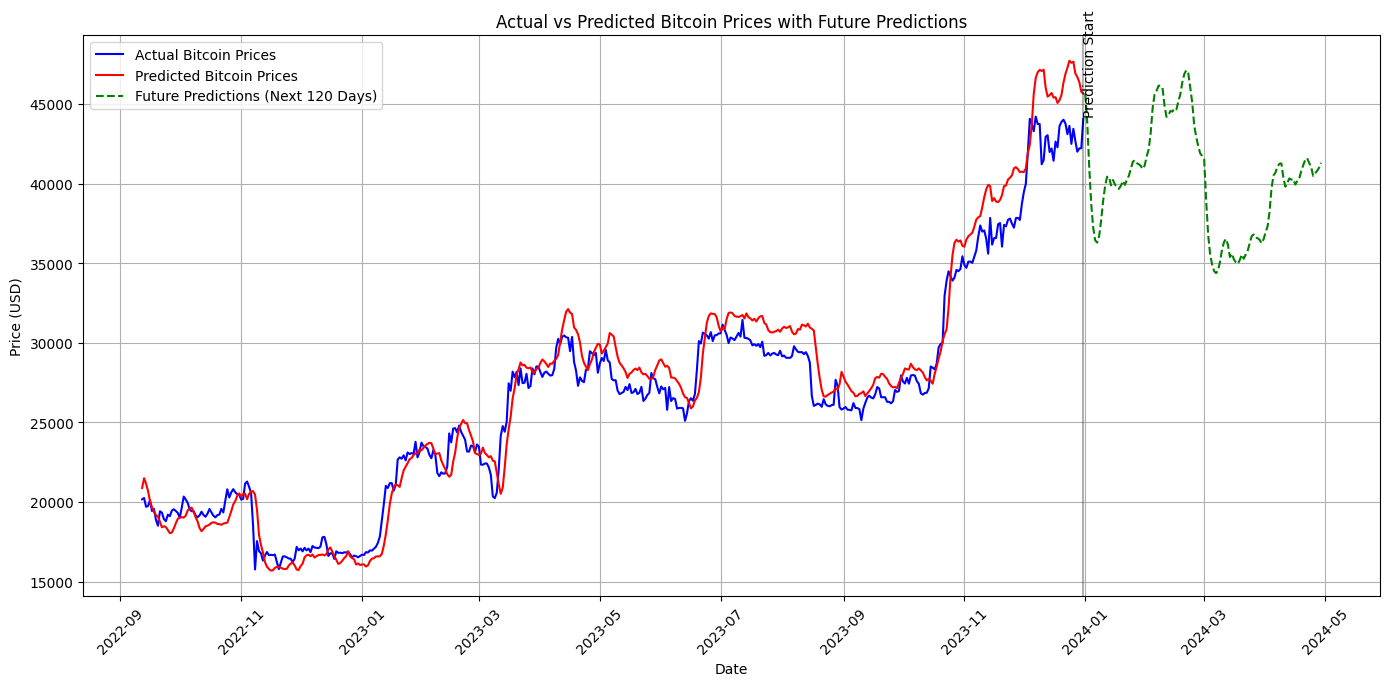

In [ ]:
# Display the predicted prices after the last actual price

# First, we need to generate future dates
# CHANGES:
# changing the period from 60 to 120
last_date = df['time'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=120, freq='D')

# Get future predictions (using the function from earlier)
future_predictions = predict_future(days_ahead=120)

# Plotting future predictions alongside actual prices
plt.figure(figsize=(14, 7))

# Get the actual dates for the test set
test_dates = df['time'].iloc[-len(y_test_actual):]

# Plot actual prices with dates
plt.plot(test_dates, y_test_actual, label='Actual Bitcoin Prices', color='blue')

# Plot predicted prices for test period
plt.plot(test_dates, y_pred, label='Predicted Bitcoin Prices', color='red')


# Future Predictions
plt.plot(future_dates, future_predictions, label='Future Predictions (Next 120 Days)',
         color='green', linestyle='--')

predicted_price = scaler_y.inverse_transform(predicted_price_scaled)

print(f"Predicted Bitcoin Price: ${predicted_price[0][0]:.2f}")

# Compare with the last known price
last_actual_price = df['PriceUSD_target'].iloc[-1]
print(f"Last Known Price: ${last_actual_price:.2f}")
print(f"Predicted Change: {((predicted_price[0][0] - last_actual_price) / last_actual_price * 100):.2f}%")

# Add a vertical line to mark where predictions start
plt.axvline(x=last_date, color='black', linestyle='-', alpha=0.3)
plt.text(last_date, plt.ylim()[1]*0.9, 'Prediction Start', rotation=90)

import pandas as pd
import numpy as np

# Make sure future_predictions is a 1D array or list
# If it's a nested list like [[x], [y], …], first unpack it:
if isinstance(future_predictions, list) and isinstance(future_predictions[0], (list, np.ndarray)):
    flat_preds = [p[0] for p in future_predictions]
else:
    flat_preds = np.array(future_predictions).reshape(-1)

# Build DataFrame
future_df = pd.DataFrame({
    'date': future_dates,
    'predicted_price_usd': flat_preds
})

# Save to CSV
future_df.to_csv('future_predictions.csv', index=False)
print("Saved future_predictions.csv!")


# Plotting
plt.title('Actual vs Predicted Bitcoin Prices with Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The Code Below is For Using Ethereum Assets

In [ ]:
# 'SplyCntCur' - this is for the supply count of the current coin
# 'CapMrktCurUSD' - this is for the market capitalization of the current coin
# 'PriceUSD' - this is for the price of the current coin
# 'TxTfrValAdjUSD' - this is for the adjusted transaction value in USD
# 'TxTfrValUSD' - this is for the transaction value in USD
# 'TxTfrCnt' - this is for the transaction count
# 'IssContNtv' - this is for the native issuance count
# 'IssContPctAnn' - this is for the annual percentage of the issuance count
#
# metrics = client.get_asset_metrics(assets='btc', metrics=['PriceUSD','HashRate','TxTfrCnt','AdrActCnt', 'SplyCur'], start_time="2013-01-01", end_time="2023-01-02", frequency='1d')
# metrics = client.get_asset_metrics(assets='btc', metrics=['PriceUSD','HashRate','TxTfrCnt','AdrActCnt', 'SplyCur'], start_time="2023-01-01", end_time="2024-01-02", frequency='1d')
metrics_eth = client.get_asset_metrics(assets='eth', metrics=['PriceUSD','HashRate','TxTfrCnt','AdrActCnt', 'SplyCur'], start_time="2017-01-01", end_time="2024-01-02", frequency='1d')

In [ ]:
# Convert the DataCollection to a pandas DataFrame
metrics_eth = pd.DataFrame(metrics_eth)
metrics_eth['time'] = pd.to_datetime(metrics_eth['time'])
metrics_eth.sort_values('time', inplace=True)

# Create features
metrics_eth['PriceUSD_target'] = metrics_eth['PriceUSD'].shift(-1)
metrics_eth.dropna(inplace=True)

# Select same features used in training
# X = df[['HashRate','AdrActCnt', 'PriceUSD', 'TxTfrCnt_per_address', 'SplyCur_per_address']].values
X_eth = metrics_eth[['PriceUSD']].values
y_eth = metrics_eth['PriceUSD_target'].values

# Scale with the SAME scaler (important!)
X_eth_scaled = scaler_X.transform(X_eth)
y_eth_scaled = scaler_y.transform(y_eth.reshape(-1, 1))

In [ ]:
time_steps = 60  # or whatever you used for Bitcoin

def create_sequences(X, y, time_steps=60):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

X_eth_seq, y_eth_seq = create_sequences(X_eth_scaled, y_eth_scaled, time_steps)


In [ ]:
# Predict ETH using Bitcoin-trained model
y_pred_eth_scaled = model.predict(X_eth_seq)

# Inverse transform to get actual prices
y_pred_eth = scaler_y.inverse_transform(y_pred_eth_scaled)
y_eth_actual = scaler_y.inverse_transform(y_eth_seq.reshape(-1, 1))

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

eth_rmse = np.sqrt(mean_squared_error(y_eth_actual, y_pred_eth))
eth_mae = mean_absolute_error(y_eth_actual, y_pred_eth)

print(f"ETH Testing RMSE: {eth_rmse:.2f}")
print(f"ETH Testing MAE: {eth_mae:.2f}")


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
ETH Testing RMSE: 401.06
ETH Testing MAE: 388.63


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
ETH Testing RMSE: 401.06
ETH Testing MAE: 388.63


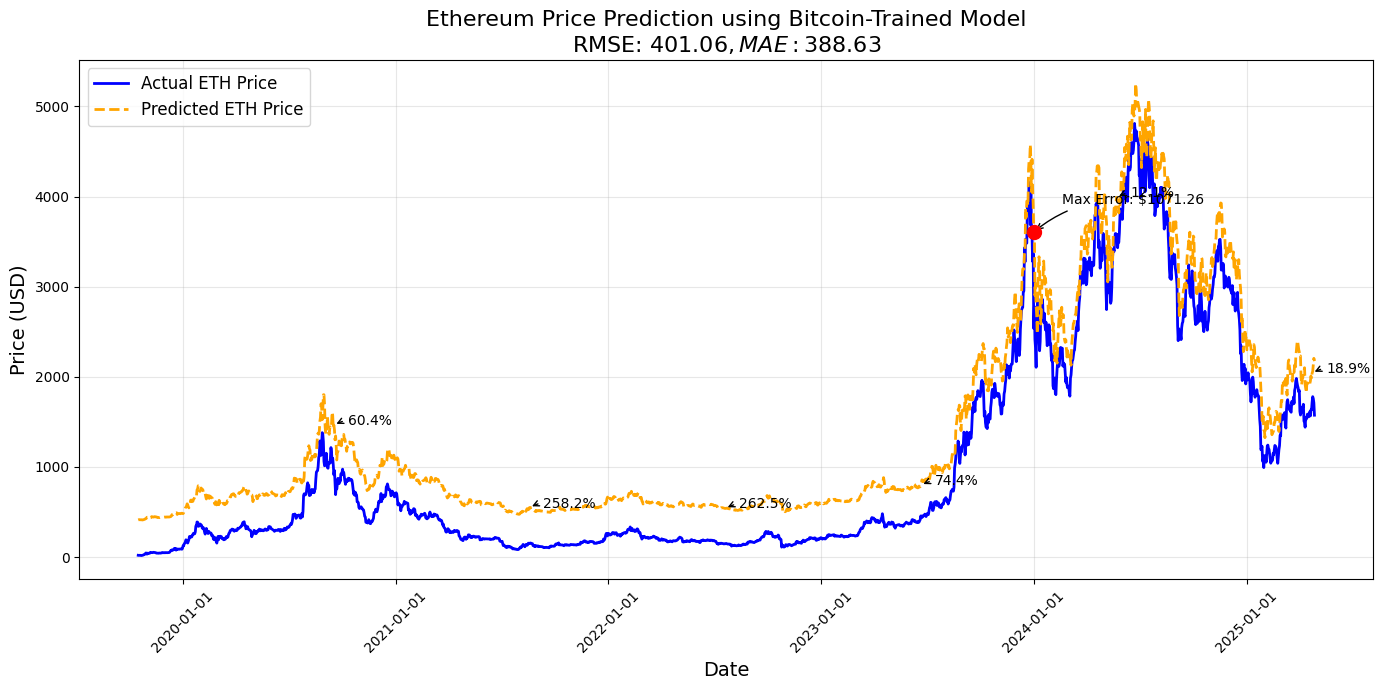

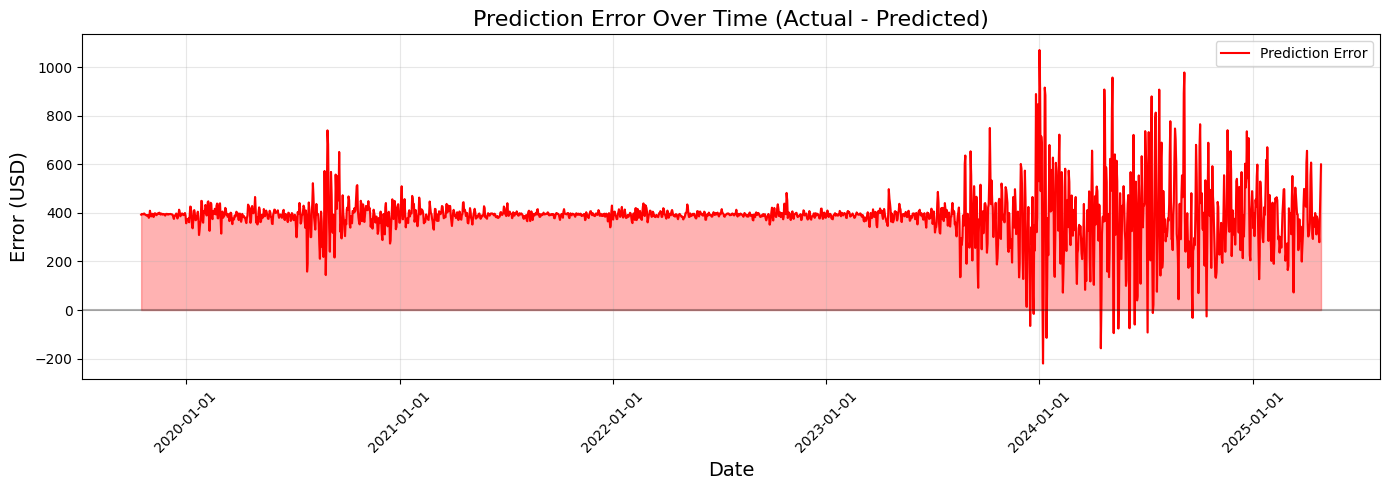

In [ ]:
# Predict ETH using Bitcoin-trained model
y_pred_eth_scaled = model.predict(X_eth_seq)

# Inverse transform to get actual prices
y_pred_eth = scaler_y.inverse_transform(y_pred_eth_scaled)
y_eth_actual = scaler_y.inverse_transform(y_eth_seq.reshape(-1, 1))

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd

eth_rmse = np.sqrt(mean_squared_error(y_eth_actual, y_pred_eth))
eth_mae = mean_absolute_error(y_eth_actual, y_pred_eth)
print(f"ETH Testing RMSE: {eth_rmse:.2f}")
print(f"ETH Testing MAE: {eth_mae:.2f}")

# Create date range for x-axis (if you have actual dates, use those instead)
# This assumes your test data represents consecutive days
# If you have actual dates in your DataFrame, use those instead
try:
    # Attempt to get actual dates if available in your data
    dates = eth_data.iloc[-len(y_eth_actual):]['time'].values
except:
    # If not available, create a date range
    dates = pd.date_range(end=pd.Timestamp.today(), periods=len(y_eth_actual))

# Create a visualization
plt.figure(figsize=(14, 7))

# Plot the actual and predicted prices
plt.plot(dates, y_eth_actual, label='Actual ETH Price', color='blue', linewidth=2)
plt.plot(dates, y_pred_eth, label='Predicted ETH Price', color='orange', linewidth=2, linestyle='--')

# Add a vertical line to indicate the end of training data if applicable
# plt.axvline(x=train_end_date, color='red', linestyle='-', alpha=0.3, label='Train-Test Split')

# Add graph elements
plt.title(f'Ethereum Price Prediction using Bitcoin-Trained Model\nRMSE: ${eth_rmse:.2f}, MAE: ${eth_mae:.2f}', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Format the x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Add annotations showing percentage error at a few points
n_points = 5  # Number of points to annotate
step = len(y_eth_actual) // (n_points + 1)
for i in range(step, len(y_eth_actual), step):
    error_pct = (y_pred_eth[i][0] - y_eth_actual[i][0]) / y_eth_actual[i][0] * 100
    plt.annotate(f'{error_pct:.1f}%',
                 xy=(dates[i], y_pred_eth[i][0]),
                 xytext=(10, 0), textcoords='offset points',
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

# Show the max and min prediction errors
max_error_idx = np.abs(y_pred_eth - y_eth_actual).argmax()
plt.scatter(dates[max_error_idx], y_pred_eth[max_error_idx], color='red', s=100, zorder=5)
plt.annotate(f'Max Error: ${abs(y_pred_eth[max_error_idx][0] - y_eth_actual[max_error_idx][0]):.2f}',
             xy=(dates[max_error_idx], y_pred_eth[max_error_idx]),
             xytext=(20, 20), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.savefig('eth_price_prediction.png', dpi=300)
plt.show()

# Additional plot: Error over time
plt.figure(figsize=(14, 5))
prediction_error = (y_pred_eth - y_eth_actual).reshape(-1)
plt.plot(dates, prediction_error, color='red', label='Prediction Error')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.fill_between(dates, prediction_error, 0, alpha=0.3, color='red' if np.mean(prediction_error) > 0 else 'green')
plt.title('Prediction Error Over Time (Actual - Predicted)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Error (USD)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('eth_prediction_error.png', dpi=300)
plt.show()